In [ ]:
!gdown 1-5zXQqKj8P4Wcd3O3u7EWhoN57VWXd_G #balanced dataset in .npz format

Downloading...
From: https://drive.google.com/uc?id=1-5zXQqKj8P4Wcd3O3u7EWhoN57VWXd_G
To: /content/data_balanced.npz
100% 4.41G/4.41G [00:34<00:00, 128MB/s]


In [ ]:
!gdown 1I6udZ-f1tjwH3aDQVq2ZdXKso4X0fbv4 #original ECG data

Downloading...
From: https://drive.google.com/uc?id=1I6udZ-f1tjwH3aDQVq2ZdXKso4X0fbv4
To: /content/ecg_data.zip
100% 1.72G/1.72G [00:17<00:00, 96.7MB/s]


In [ ]:
!unzip -q ecg_data 

In [ ]:
!pip install ecg-plot

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import ecg_plot

import tensorflow as tf
from tensorflow import keras

from keras.utils import plot_model
from keras import layers

from keras.layers import Input, Dense, Dropout, Activation 
from keras.layers import BatchNormalization, Add, Flatten, TimeDistributed
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPool1D
from keras.layers import MaxPooling1D, ZeroPadding1D, LSTM
from keras.models import Sequential, Model
from keras.utils import plot_model

from keras.utils import to_categorical

from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

from scipy import optimize
from scipy.io import loadmat
import os


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def load_data(fname, x, y):
  with open(fname, 'rb') as f:
    np_data = np.load(f)
    X = np_data[x]
    Y = np_data[y]
  return X, Y

def save_data(fname, X, Y):
  with open(fname, "wb") as f:
    np.savez(f, X=X, Y=Y)


In [ ]:
X,Y = load_data("ecg_data.npz", 'X', 'Y')

FileNotFoundError: ignored

In [ ]:
len(Y)

36755

##Data Augmentation

In [ ]:
labels = ["SR", "SA", "SB", "AF", "AFIB"]
labels_bin = ["Normal", "Abnormal"]

def sample(X, Y, fn_recording, label, times=1, labels=labels):
  for i in range(times):
    data = loadmat("ecg_data/data/"+ fn_recording + ".mat")
    data = data['val']
    X.append(data)
    if label in ["SR", "SA", "SB"]:
      Y.append(0)
    else:
      Y.append(1)

def read_ecg_data():
  X = list()
  Y = list()
  counter = 0

  with open("ecg_data/labelled.txt") as fn_label:  
    for line in fn_label:
      fn_recording, label = (line.strip()).split(",")
      if(label == "SB"): #Undersampling
        if(counter%2 == 0):
          sample(X,Y,fn_recording, label)
      elif((label == "SA") or (label == "AFIB")): #Oversampling
        sample(X,Y,fn_recording,label, times=5)
      else:
        sample(X,Y,fn_recording,label)
      counter += 1
  return X, Y


In [ ]:
X, Y = read_ecg_data()

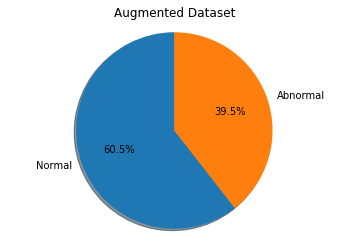

In [ ]:
def visualize_pie(Y, labels=labels):
  sizes = list()

  for label in labels:
    sizes.append(Y.count(label))

  fig1, ax1 = plt.subplots()
  ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
          shadow=True, startangle=90)
  ax1.axis('equal')
  plt.title('Augmented Dataset')
  plt.savefig("pie_chart.png")

  plt.show()

def compare():
  fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
  autopct = "%.2f"
  
  sizes = list()
  for label in labels:
    sizes.append(Y.count(label))

  iris.target.value_counts().plot.pie(autopct=autopct, ax=axs[0])
  axs[0].set_title("Original")
  y.value_counts().plot.pie(autopct=autopct, ax=axs[1])
  axs[1].set_title("Imbalanced")
  fig.tight_layout()

visualize_pie(Y, labels=labels_bin)


In [ ]:
weights = class_weight.compute_class_weight(class_weight='balanced',
                                  classes=np.unique(Y),
                                  y=Y)

In [ ]:
X = np.stack(X, axis=0)
Y = to_categorical(Y,2)

In [ ]:
save_data("data_balanced.npz", X, Y)

##Shuffling and dividing the dataset into training and testing set

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test= train_test_split(X,Y,test_size=0.20, random_state=0)

del X, Y

#Preprocessing the data

##Filtering by Butterworth Low-pass and Butterworth Notch filter

In [ ]:
from scipy.signal import butter, filtfilt, iirnotch
sample_rate = 500

def butter_low(cutoff, sample_rate, order):
  nyq = 0.5 * sample_rate
  normal_cutoff = cutoff / nyq
  b, a = butter(order, normal_cutoff, btype='low', analog=False)
  return b, a

def filter_notch(data, cutoff, sample_rate):
  b, a = iirnotch(cutoff, Q = 0.005, fs = sample_rate)
  filtered_data = filtfilt(b, a, data)
  return filtered_data

def filter_lowpass(data, cutoff, sample_rate, order):
  
  b, a = butter_low(cutoff, sample_rate, order=order)
  
  filtered_data = filtfilt(b, a, data)
  
  return filtered_data

def denoise(lead_12, sample_rate=500):
  """
  lead_12 will be a numpy array of shape: (12, 5000)
  Butterworth Low-pass cutoff frequency will be 45 Hz
  Butterworth Notch filter's rejection frequency will be 0.05 Hz
  """
  filtered_pre = filter_lowpass(lead_12, cutoff=45, sample_rate=sample_rate, order=3)
  
  filtered = filter_notch(filtered_pre, cutoff=0.05, sample_rate=sample_rate)
   
  return filtered


##Denoising and Normalizing the data
The datasets are divided into batches and saved

In [ ]:
def batch_preprocess(X, Y, name, batch=2048):

  X_new = list()
  i = 0
  size = len(X)

  while(batch*i < size):
    fname = f"{name}_data_filtered_{i}.npz"
      
    if(batch*(i+1) < size):
      X_batch = X[i*batch:(i+1)*batch,:,:]
      Y_batch = Y[i*batch:(i+1)*batch,:]
    else:
      X_batch = X[i*batch:,:,:]
      Y_batch = Y[i*batch:,:]
      
    filt_ecg = denoise(X_batch)
    norm_ecg = (filt_ecg - np.average(filt_ecg)) / (np.std(filt_ecg))
    
    with open(fname, 'wb') as f:
      np.savez(f, X_batch=norm_ecg, Y_batch=Y_batch)
    with open(fname, 'wb') as f:
      np.savez(f, X_batch=norm_ecg, Y_batch=Y_batch)
    
    i += 1

In [ ]:
batch_preprocess(X_train, Y_train, name="train")

In [ ]:
batch_preprocess(X_test, Y_test, name="test")

In [ ]:
X_test = X_test.reshape(len(X_test), 12, 5000)
X_test = (X_test - np.average(X_test))/(np.std(X_test))

In [ ]:
del X_train, Y_train

##Open batch of data

In [ ]:
def load_batch(fname, i):
  fname = f"{fname}_{i}.npz"
  X_batch, Y_batch = load_data(fname, 'X_batch', 'Y_batch')

  return X_batch, Y_batch
  

##Batch Generator

In [ ]:
def batch_generator(fname, length=14):
    while True:
        for i in range(length):
            np_data = np.load(f"{fname}{i}.npz")
            X_batch = np_data['X_batch']
            Y_batch = np_data['Y_batch']
            yield X_batch, Y_batch


##Plotting ECG 

In [ ]:
def plot_ecg(ecg_12, lead=0, sample_rate=500, title="ECG"):
  ecg_1 = ecg_12[lead, :]

  times = np.arange(len(ecg_1))/sample_rate
  
  plt.figure(figsize=(12, 4))
  plt.plot(ecg_1)
  plt.xlabel("Time/seconds")
  plt.ylabel("mV")
  plt.title(title)
  plt.show()

def compare_ecg(ecg_12_raw, ecg_12_filt, lead=0, sample_rate=500, 
                title="Comparison of a Raw and Filtered ECG signal"):
  ecg_1 = ecg_12_raw[lead, :]
  ecg_2 = ecg_12_filt[lead, :]
  times = np.arange(len(ecg_1))/sample_rate
  
  plt.figure(figsize=(12, 4))
  plt.plot(ecg_1, label="Raw ECG", c='b')
  plt.plot(ecg_2, label="Filtered ECG", c='y')
  plt.xlabel("Time/seconds")
  plt.ylabel("mV")
  plt.title("Filtering")
  plt.legend()
  plt.show()

def show_ecg(ecg_12, sample_rate=500, title="ECG"):
  ecg_plot.plot(ecg_12/1000, sample_rate=sample_rate, title=title)
  ecg_plot.show()


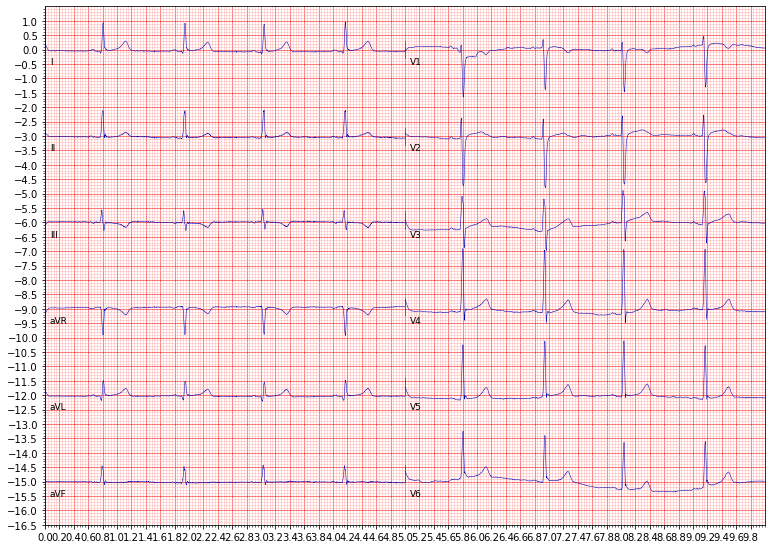

In [ ]:
show_ecg(X[5,:,:2500],title="")

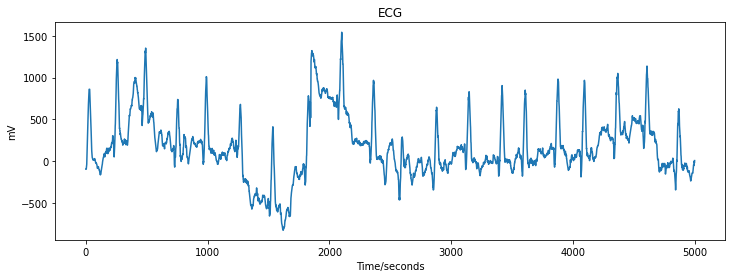

In [ ]:
plot_ecg(X[0,:,:], lead=6)


#Model Training

##Lenet_5

In [ ]:
model3 = Sequential()

model3.add(Input(shape = (5000,12)))

model3.add(Conv1D(12, kernel_size=2, strides=1, padding='same', activation='relu'))
model3.add(MaxPooling1D(pool_size=1, strides=1))

model3.add(Conv1D(12, kernel_size=4, strides=1, padding='same', activation='relu'))
model3.add(MaxPooling1D(pool_size=1, strides=1))

model3.add(Conv1D(12, kernel_size=8, strides=1, padding='same', activation='relu'))
model3.add(MaxPooling1D(pool_size=1, strides=1))

model3.add(tf.keras.layers.Dropout(.3, noise_shape=None, seed=None))
model3.add(tf.keras.layers.Flatten(data_format=None))
model3.add(tf.keras.layers.BatchNormalization())

model3.add(Dense(13, activation='relu'))
model3.add(Dense(5, activation='softmax'))
model3.summary()

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model3.compile(optimizer=opt,
               loss='categorical_crossentropy',
               metrics=['accuracy'])



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 5000, 12)          300       
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 5000, 12)         0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 5000, 12)          588       
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 5000, 12)         0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 5000, 12)          1164      
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 5000, 12)        

In [ ]:
history2 = model3.fit(X_batch_re, Y_batch, epochs = 10, validation_split = 0.20, batch_size = 25, verbose = 1)

##Residual Networks

In [ ]:
def residual_network_1d():
    n_feature_maps = 64
    input_shape = (5000,12)
    input_layer = Input(input_shape)

    # BLOCK 1

    conv_x = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=8, padding='same')(input_layer)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # expand channels for the sum
    shortcut_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(input_layer)
    shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

    output_block_1 = keras.layers.add([shortcut_y, conv_z])
    output_block_1 = keras.layers.Activation('relu')(output_block_1)

    # BLOCK 2

    conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_1)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # expand channels for the sum
    shortcut_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=1, padding='same')(output_block_1)
    shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

    output_block_2 = keras.layers.add([shortcut_y, conv_z])
    output_block_2 = keras.layers.Activation('relu')(output_block_2)

    # BLOCK 3

    conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_2)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # no need to expand channels because they are equal
    shortcut_y = keras.layers.BatchNormalization()(output_block_2)

    output_block_3 = keras.layers.add([shortcut_y, conv_z])
    output_block_3 = keras.layers.Activation('relu')(output_block_3)
    
    # FINAL

    gap_layer = keras.layers.GlobalAveragePooling1D()(output_block_3)

    output_layer = keras.layers.Dense(2, activation='sigmoid')(gap_layer)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)

    model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics=['accuracy']
                  )

    plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

    return model

model_rn = residual_network_1d()
model_rn.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 5000, 12)]   0           []                               
                                                                                                  
 conv1d_11 (Conv1D)             (None, 5000, 64)     6208        ['input_2[0][0]']                
                                                                                                  
 batch_normalization_12 (BatchN  (None, 5000, 64)    256         ['conv1d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_9 (Activation)      (None, 5000, 64)     0           ['batch_normalization_12[0]

In [ ]:
weights = {0:0.82591794, 1:1.26706426}

In [ ]:
for i in range(0,15):
  X_batch, Y_batch = load_batch("train_data_filtered", i)
  X_batch = X_batch.reshape((len(X_batch),5000,12))
  history = model_rn.fit(X_batch, 
                         Y_batch,
                         epochs = 5, 
                         validation_split = 0.20, 
                         batch_size = 32, 
                         class_weight=weights)
  histories.append(history)

Epoch 1/5
52/52 [==============================] - 7s 72ms/step - loss: 0.6064 - accuracy: 0.6947 - val_loss: 0.7420 - val_accuracy: 0.5341
Epoch 2/5
52/52 [==============================] - 3s 62ms/step - loss: 0.5186 - accuracy: 0.7399 - val_loss: 1.6974 - val_accuracy: 0.6220
Epoch 3/5
52/52 [==============================] - 3s 62ms/step - loss: 0.4878 - accuracy: 0.7814 - val_loss: 1.0574 - val_accuracy: 0.6756
Epoch 4/5
52/52 [==============================] - 3s 62ms/step - loss: 0.4488 - accuracy: 0.7900 - val_loss: 1.5751 - val_accuracy: 0.6561
Epoch 5/5
52/52 [==============================] - 3s 62ms/step - loss: 0.4444 - accuracy: 0.7973 - val_loss: 0.9027 - val_accuracy: 0.7146
Epoch 1/5
52/52 [==============================] - 3s 64ms/step - loss: 0.4571 - accuracy: 0.7833 - val_loss: 0.6485 - val_accuracy: 0.6829
Epoch 2/5
52/52 [==============================] - 3s 62ms/step - loss: 0.4169 - accuracy: 0.8114 - val_loss: 0.4259 - val_accuracy: 0.8415
Epoch 3/5
52/52 [===

##CNN-LSTM

In [ ]:
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), 
                          input_shape=(None, 1250, 12)))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(5, activation='softmax'))

Evaluation

In [ ]:
X_train = X_train.reshape((X_train.shape[0],5000, 12))
X_test = X_test.reshape((X_test.shape[0], 5000, 12))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
history = model.fit(X_train, Y_train, epochs=50, batch_size=64, verbose=1)

Epoch 1/50
460/460 [==============================] - 19s 15ms/step - loss: 1.5864 - accuracy: 0.2496
Epoch 2/50
460/460 [==============================] - 7s 14ms/step - loss: 1.5666 - accuracy: 0.2644
Epoch 3/50
460/460 [==============================] - 7s 14ms/step - loss: 1.5585 - accuracy: 0.2662
Epoch 4/50
460/460 [==============================] - 7s 14ms/step - loss: 1.5526 - accuracy: 0.2709
Epoch 5/50
460/460 [==============================] - 7s 14ms/step - loss: 1.5469 - accuracy: 0.2767
Epoch 6/50
460/460 [==============================] - 7s 14ms/step - loss: 1.5458 - accuracy: 0.2747
Epoch 7/50
460/460 [==============================] - 7s 14ms/step - loss: 1.5442 - accuracy: 0.2755
Epoch 8/50
460/460 [==============================] - 7s 14ms/step - loss: 1.5432 - accuracy: 0.2777
Epoch 9/50
460/460 [==============================] - 7s 14ms/step - loss: 1.5550 - accuracy: 0.2708
Epoch 10/50
460/460 [==============================] - 7s 14ms/step - loss: 1.5818 - accur

KeyboardInterrupt: ignored

In [ ]:
del model

##LSTM

In [ ]:
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(5000,12), return_sequences=True))
lstm_model.add(LSTM(64))
lstm_model.add(Dense(32, activation = 'relu'))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(5, activation = 'softmax'))

lstm_model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

lstm_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 5000, 64)          19712     
                                                                 
 lstm_7 (LSTM)               (None, 64)                33024     
                                                                 
 dense_11 (Dense)            (None, 32)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_12 (Dense)            (None, 5)                 165       
                                                                 
Total params: 54,981
Trainable params: 54,981
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = lstm_model.fit(X_train, Y_train, epochs = 40, validation_split = 0.20, batch_size = 25, verbose = 1)

Epoch 1/20
941/941 [==============================] - 315s 326ms/step - loss: 1.5493 - accuracy: 0.2778 - val_loss: 1.5327 - val_accuracy: 0.2908
Epoch 2/20
941/941 [==============================] - 301s 320ms/step - loss: 1.5377 - accuracy: 0.2870 - val_loss: 1.5317 - val_accuracy: 0.3093
Epoch 3/20
941/941 [==============================] - 303s 322ms/step - loss: 1.5352 - accuracy: 0.2898 - val_loss: 1.5314 - val_accuracy: 0.3045
Epoch 4/20
941/941 [==============================] - 303s 322ms/step - loss: 1.5330 - accuracy: 0.2889 - val_loss: 1.5299 - val_accuracy: 0.3098
Epoch 5/20
941/941 [==============================] - 302s 321ms/step - loss: 1.5239 - accuracy: 0.3031 - val_loss: 1.5236 - val_accuracy: 0.3035
Epoch 6/20
941/941 [==============================] - 302s 321ms/step - loss: 1.4371 - accuracy: 0.3718 - val_loss: 1.3781 - val_accuracy: 0.4052
Epoch 7/20
941/941 [==============================] - 302s 321ms/step - loss: 1.3670 - accuracy: 0.4134 - val_loss: 1.2990 -

In [ ]:
lstm_model.save('/content/drive/MyDrive/ArrythmiaRasp')
np.save('/content/drive/MyDrive/ArrythmiaRasp/my_history.npy',history.history)

##Merging

In [ ]:
mergedOut = Add()([model1.output, lenet_5_model.output])
newModel = Model([model1.input, lenet_5_model.input], mergedOut)
newModel.summary()

newModel.compile(optimizer=opt,
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 conv1d_input (InputLayer)      [(None, 5000, 12)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 5000, 6)      222         ['conv1d_input[0][0]']           
                                                                                                  
 batch_normalization (BatchNorm  (None, 5000, 6)     24          ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 5000, 6)      0           ['batch_normalization[0][0]']

In [ ]:
newModel.fit([X_train, X_train], Y_train, epochs=50, batch_size=20, shuffle=False)

InternalError: ignored

In [ ]:
tf.config.run_functions_eagerly(True)

#Model Conversion

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model_rn.save('/content/drive/MyDrive/ArrythmiaRasp/Saved')

In [ ]:
model_rn.save_weights('/content/drive/MyDrive/ArrythmiaRasp/Saved')

#Model evaluation

In [ ]:
X_batch, Y_batch = open_data("train", 1)
X_batch = X_batch.reshape((len(X_batch),5000,12))
results = model_rn.evaluate(X_batch, Y_batch, batch_size=128)

In [ ]:
X_test = X_test.reshape((len(X_test),5000,12))
results = model_rn.evaluate(X_test, Y_test, batch_size=128)

58/58 [==============================] - 3s 53ms/step - loss: 0.0374 - accuracy: 0.9871


In [ ]:
from sklearn.metrics import plot_confusion_matrix
class estimator:
  _estimator_type = ''
  classes_=[]
  def __init__(self, model, classes):
    self.model = model
    self._estimator_type = 'classifier'
    self.classes_ = classes
  def predict(self, X):
    y_prob= self.model.predict(X)
    y_pred = y_prob.argmax(axis=1)
    return y_pred

labels = ["SR", "SA", "SB", "AF", "AFIB"]

In [ ]:
classifier = estimator(model_rn, labels)
plot_confusion_matrix(estimator=classifier, X=X_batch, y_true=Y_batch)

In [ ]:
figsize = (12,12)
plot_confusion_matrix(estimator=classifier, X=test_data, 
                      y_true=test_labels, cmap='Blues', 
                      normalize='true', ax=plt.subplots(figsize=figsize)[1])

In [ ]:
preds = model_rn.predict(X_test)
preds

230/230 [==============================] - 4s 15ms/step


array([[2.1747560e-03, 9.9769324e-01],
       [9.9997044e-01, 2.7877992e-05],
       [9.9999464e-01, 5.3670069e-06],
       ...,
       [9.8866397e-01, 1.1178374e-02],
       [9.9958438e-01, 3.9734170e-04],
       [5.4685483e-03, 9.9489921e-01]], dtype=float32)

In [ ]:
y_pred = (preds > 0.5)
y_pred = np.argmax(y_pred, axis=1)
y_true = Y_test>0.5
y_true = np.argmax(y_true, axis=1)

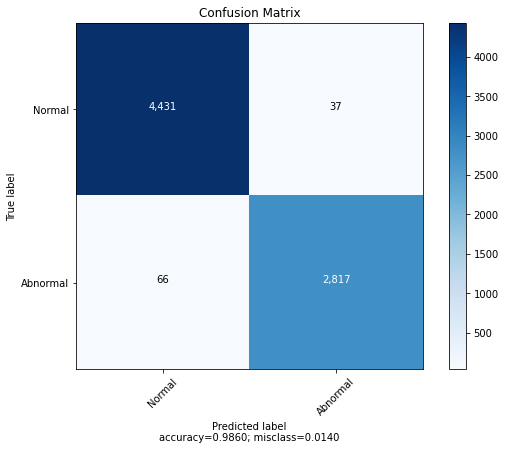

In [ ]:
import sklearn.metrics
cm = sklearn.metrics.confusion_matrix(y_true, y_pred)

plot_confusion_matrix(cm=cm,
                      normalize=False,
                      target_names = labels_bin,
                      title        = "Confusion Matrix")

In [ ]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig("confusion_matrix.png", bbox_inches='tight')
    plt.show()


#Save Results

In [ ]:
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model_rn.save_weights("/content/drive/MyDrive/ArrythmiaRasp/Saved/weights_rnn.h5")


In [ ]:
import pickle

with open("/content/drive/MyDrive/ArrythmiaRasp/Saved/histories", "wb") as fp:
    pickle.dump(histories, fp)


In [ ]:
with open("test", "rb") as fp:
  histories = pickle.load(fp)

len(histories)

30

#TensorFlowLite
##Converting the model

In [ ]:
saved_model_dir = '/content/drive/MyDrive/ArrythmiaRasp/Saved'

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) # path to the SavedModel directory
tflite_model = converter.convert()

In [ ]:
with open('/content/drive/MyDrive/ArrythmiaRasp/Saved/model_rn.tflite', 'wb') as f:
  f.write(tflite_model)

##Dynamic range quantization

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

In [ ]:
with open('/content/drive/MyDrive/ArrythmiaRasp/Saved/model_rn_quant.tflite', 'wb') as f:
  f.write(tflite_quant_model)

##Float 16 quantization

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_float16_model = converter.convert()

In [ ]:
!gdown 1-B5Lw-0VDCcmTuZDOzLBUTJe_BddoD9D

Downloading...
From: https://drive.google.com/uc?id=1-B5Lw-0VDCcmTuZDOzLBUTJe_BddoD9D
To: /content/saved_model.pb
100% 1.01M/1.01M [00:00<00:00, 109MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tflite_runtime


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 6.5 MB/s 


interpreter = tf.lite.Interpreter(model_content=tflite_quant_model)
signatures = interpreter.get_signature_list()
print(signatures)
